In [1]:
from sps4lat import model as mod
from sps4lat import preprocessing as pre
from sps4lat import optimize as opti
from sps4lat import utils as uti
from fgspectra import cross as fgc
from fgspectra import frequency as fgf
from fgspectra import power as fgp
import healpy as hp 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as opt
warnings.filterwarnings("ignore")


In [2]:
def _get_order_synfast(cl):
    shape = cl.shape
    N_freqs = shape[0]
    lst_idx = []
    for k in range(N_freqs):
        T=np.where(np.eye(N_freqs,k=k) == 1)
        lst = [[T[0][i],T[1][i]] for i in range(len(T[0]))]
        lst_idx.extend(lst)
    res = [cl[i,j,:] for i,j in lst_idx]
    return res

In [3]:
#### SKY SIMULATION ####
nside = 512
lmax = 3*nside-1
freqs = np.array([30.,44.,70.,100.,143.,217.,353.])
N = len(freqs)

## Noise ##
nwhite = np.array([145.,149.,137.,65.,43.,66.,200.])*np.pi/180./60./10.
noise = mod.WhiteNoise(ell=np.linspace(0,lmax,lmax+1), nu=freqs, nwhite=nwhite)

## Foregrounds ##
# fgs_sed = fgf.ThermalSZ(nu=freqs, nu_0=150.)
# fgs_power = fgp.tSZ_150_bat()
# fgs_power.set_defaults(ell=np.linspace(0,lmax,lmax+1).astype('int'), ell_0=3000, amp=4.66)
fgs_dict = {'sed_kwargs': {'kwseq': [{'nu': freqs, 'nu_0': 150.}, 
                                     {'nu': freqs, 'nu_0': 150., 'temp': 9.7, 'beta': 2.08}]}, 
            'cl_kwargs': {'kwseq': [{'ell': np.linspace(0,lmax,lmax+1), 'ell_0': 3000, 'amp': 4.66}, 
                                    {'ell': np.linspace(0,lmax,lmax+1), 'alpha': 2.-1.20, 'ell_0': 3000, 'amp': 6.1}, 
                                    {'ell': np.linspace(0,lmax,lmax+1), 'ell_0': 3000, 'amp': -0.09*np.sqrt(6.1*4.66)}]}}
fgs = fgc.SZxCIB()
fgs.set_defaults(**fgs_dict)
# fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed, cl=fgs_power)
fgs_dl = fgs.eval()
ell=np.linspace(0,lmax,lmax+1)
factor = ell*(ell+1)/2./np.pi
fgs_cl = np.nan_to_num(fgs_dl/factor)

## CMB ##
cmb_cls = mod.CMB(ell=np.linspace(0,lmax,lmax+1))
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)

## Total ##
model_init = fgc.Sum(cmb, noise)

cl = model_init.eval() + fgs_cl
print(cl.shape)
## Generating maps ##
mp = hp.synfast(_get_order_synfast(cl),nside=nside, new=True, verbose=False, pol=False)
for i,fr in enumerate(freqs): 
    filename = '../data/test/maps/test_pl/{:d}GHz.fits'.format(int(fr))
    hp.write_map(filename, mp[i],overwrite = True)

(7, 7, 1536)


In [4]:
#### PLOTS OF MAPS ####
map_list = []
for i,fr in enumerate(freqs): 
    filename = '../data/test/maps/test_pl/{:d}GHz.fits'.format(int(fr))
    map_list.append(hp.read_map(filename, verbose = False))
alms = uti.get_alms(map_list)


In [5]:
nbins = 100

#### BINNING EMP COV + PLOT ####
bins = np.linspace(5,lmax,nbins).astype('int')
emp_cov = pre.empirical_covmat(alms)[...,2:]
    ell = np.linspace(2,lmax,lmax-1)
ell_mean, emp_cov_binned = uti.bin_spectra(ell=ell, spectra=emp_cov, bins=bins) 

bins_max = bins[1:]
bins_min = bins[:-1]
n_bins = len(bins) - 1
weights = np.array([(bins_max[i] - bins_min[i]) * (bins_max[i] + bins_min[i]) for i in range(n_bins)])

100


In [38]:
#### MODEL OF THE COVMAT ####

## Noise ##
noise = mod.WhiteNoise(ell=ell_mean, nu=freqs, nwhite=None)

## CMB ##
cmb_cls = mod.FreeCls(ell=ell_mean, cls=None)
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)
    
## FGS ##
fgs_cls1 = mod.FreeCls(ell=ell_mean, cls=None)
fgs_cls2 = mod.FreeCls(ell=ell_mean, cls=None)
fgs_cls1xcls2 = mod.FreeCls(ell=ell_mean, cls=None)

fgs_sed1 = fgf.FreeSED(nu=freqs, sed=np.array([2.05,1.99,1.84,1.58,1.09,0.01,-2.35]))
fgs_sed2 = fgf.FreeSED(nu=freqs, sed=np.array([2.85e-02, 6.27e-02, 1.66e-01, 3.66e-01, 8.80e-01, 3.07e+00, 2.41e+01]))
fgs_sed = fgf.Join(fgs_sed1, fgs_sed2)
fgs_cls = fgp.PowerSpectraAndCovariance(fgs_cls1, fgs_cls2, fgs_cls1xcls2)

fgs = mod.CorrelatedFactorizedCrossSpectrum(sed=fgs_sed, cl=fgs_cls)

## Total ##
cl_mod = mod.Sum(cmb,fgs,noise)


#### STARTING POINT TOF THE OPTMIZATION ####

def start(emp_cov, dimension, bins):
    n_bins = len(bins) - 1
    bins_max = bins[1:]
    bins_min = bins[:-1]
    weights = np.array(
        [(bins_max[i] - bins_min[i]) * (bins_max[i] + bins_min[i]) for i in
         range(n_bins)])
    emp_tot = np.einsum('b,ijb->ij', weights/n_bins, emp_cov)
    _,eigvects = np.linalg.eigh(emp_tot)
    noise = np.diag(emp_tot)
    A = eigvects[::-1,::-1]
    p_l = np.einsum('ba,bcl,cd->adl',A,emp_cov,A)
    return noise, A[:,:dimension], p_l[:dimension,:dimension,:]

noise,A,pl = start(emp_cov_binned,3,bins)

## Start dictionary ##
# dict_start = {'kwseq': [{'cl_kwargs': {'cls': pl[0,0,:]}}, 
#                         {'cl_kwargs': {'cls': pl[1,1,:]}}, 
#                         {'nwhite': noise}]}

dict_start = {'kwseq': [{'cl_kwargs': {'cls': pl[2,2,:]}}, 
                        {'cl_kwargs': {'kwseq': [{'cls': pl[1,1,:]},
                                                 {'cls': pl[0,0,:]},
                                                 {'cls': pl[0,1,:]}]}},
                        {'nwhite': noise}]}

mat_start = cl_mod.eval(**dict_start)

#### OPTIMIZATION ####

cl_mod.prepare_for_arrays(dict_start)
theta_start = cl_mod.kwargs2array(dict_start)

min_bounds_dict = {'kwseq': [{'cl_kwargs': {'cls': np.zeros(len(bins)) + 1e-25}}, 
                              {'cl_kwargs': {'kwseq': [{'cls': np.zeros(len(bins)) + 1e-25},
                                                       {'cls': np.zeros(len(bins)) + 1e-25},
                                                       {'cls': np.zeros(len(bins)) -np.inf}]}},
                              {'nwhite': np.zeros(len(freqs)) - np.inf}]}
min_bounds_array = cl_mod.kwargs2array(min_bounds_dict)
bounds = opt.Bounds(lb=min_bounds_array,ub=np.inf * np.ones(len(theta_start)),keep_feasible=True)

param_optimised_deriv, res = opti.optimiser_test(emp_cov=emp_cov_binned, model=cl_mod, 
                                                 param_start=dict_start, bins=bins, deriv=True, 
                                                 kwargs_opt = {'bounds':bounds,'method':'TNC', 
                                                              'options':{'ftol': 1e-15, 'gtol': 1e-15, 'xtol':1e-15,
                                                                         'eps': 1e-15, 'maxfun': 100000, 'maxiter': 100000,
                                                                        'eta':0.99999}})


{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842902, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.0343866 , 0.02776732, 0.02477144, 0.02118984, 0.01891864,
       0.01679803, 0.01495791, 0.01411803, 0.0127192 , 0.01145697,
       0.01093377, 0.00998988, 0.00929536, 0.00887534, 0.00844376,
       0.00789679, 0.00738791, 0.00709428, 0.00664746, 0.00648249,
       0.00610304, 0.00581822, 0.00547756, 0.00533466, 0.00514174,
       0.00489332, 0.0048172 , 0.00467222, 0.00450096, 0.00430028,
       0.00427249, 0.00420006, 0.00407204, 0.00389307, 0.00375531,
       0.00365395, 0.00356644, 0.00343796, 0.00340168, 0.00334756,
       0.00324427, 0.00323885, 0.0031156 , 0.00308595, 0.00303315,
       0.00304995, 0.00296171, 0.00294201, 0.00283325, 0.00280552,
       0.00271714, 0.00265768, 0.00259065, 0.00254869, 0.00245492,
       0.00237432, 0.00231751, 0.00225185, 0.00222792, 0.00217058,
       0.00214336, 0.00207392, 0.00204854, 0.00205555, 0.00200257,
       0.00199454, 0.00197145

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271912, 0.01145688,
       0.01093368, 0.00998979, 0.00929527, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648244,
       0.00610299, 0.00581817, 0.0054775 , 0.0053346 , 0.00514167,
       0.00489324, 0.00481712, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365386, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296156, 0.00294184, 0.00283308, 0.00280535,
       0.00271699, 0.00265754, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207386, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271912, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648244,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514167,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365386, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296156, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

In [39]:
print("End kl :", res.fun) 
print("Success :", res.success) 
print("Message :", res.message) 
print("Number iterations :", res.nit) 
print("number call fun :", res.nfev)

End kl : 17190775.203598276
Success : False
Message : Linear search failed
Number iterations : 10
number call fun : 111


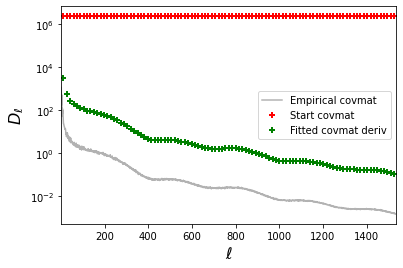

In [40]:
#### PLOT OF BEST-FIT ####

cov_opti_deriv = cl_mod.eval(**param_optimised_deriv)
i=5 #freq to plot
plt.figure()
plt.plot(ell,emp_cov[i,i,:],alpha = .3, c = 'k', label = 'Empirical covmat')
plt.scatter(ell_mean,mat_start[i,i,:],lw=2, c = 'r', label = 'Start covmat', marker = '+')
plt.scatter(ell_mean,np.abs(cov_opti_deriv[i,i,:]),lw=2, c = 'g', label = 'Fitted covmat deriv', marker = '+')
plt.yscale('log')

plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax)
plt.ylabel('$D_\ell$', fontsize =16)
# plt.yscale('log')
plt.legend()
plt.show()

In [9]:
#### WIENER FILETERING ####

lst = cl_mod.eval_terms(**param_optimised_deriv)
cpt = 0
fr = 4
inv_R = (np.linalg.inv(cov_opti_deriv.T)).T
w = np.einsum('abl,bcl->acl',lst[cpt],inv_R)
w_full = np.zeros((N,N,lmax+1))
bins_max = bins[1:]
bins_min = bins[:-1]
for i in range(len(bins)-1):
    w_full[...,bins_min[i]:bins_max[i]] = np.tile(w[...,i,np.newaxis],bins_max[i]-bins_min[i])
alm_filter  = alms.copy()
print(alms.shape)
for l in range(0,lmax-1) : 
    ind_list = []
    for m in range(0,l+1):
        ind_list.append(hp.Alm.getidx(lmax,l,m)) 
    alm_filter[:,ind_list] = np.dot(w_full[:,:,l],alms[:,ind_list])
    

(7, 1180416)


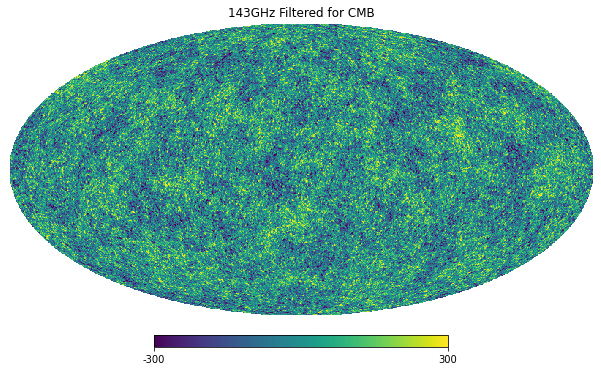

In [10]:
#### WIENER FILETERED MAPS ####

maps_resulting = []
for alm in alm_filter:
    maps_resulting.append(hp.alm2map(alm, nside=nside, verbose = False))
    
hp.mollview(maps_resulting[fr], min=-300,max=300, title = '{:d}GHz Filtered for CMB'.format(int(freqs[fr])))


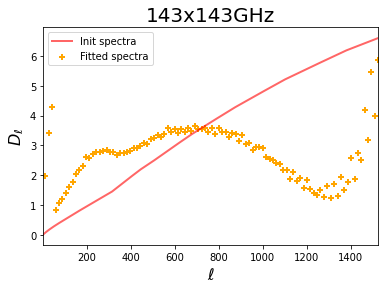

In [21]:
# fgs_sed = fgf.ThermalSZ(nu=freqs, nu_0=150.)
# fgs_power = fgp.tSZ_150_bat()
# fgs_power.set_defaults(ell=np.linspace(0,lmax,lmax+1).astype('int'), ell_0=3000, amp = 4.66)
# fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed,cl=fgs_power)
fgs_dict = {'sed_kwargs': {'kwseq': [{'nu': freqs, 'nu_0': 150.}, 
                                     {'nu': freqs, 'nu_0': 150., 'temp': 9.7, 'beta': 2.08}]}, 
            'cl_kwargs': {'kwseq': [{'ell': np.linspace(0,lmax,lmax+1), 'ell_0': 3000, 'amp': 4.66}, 
                                    {'ell': np.linspace(0,lmax,lmax+1), 'alpha': 2.-1.20, 'ell_0': 3000, 'amp': 6.1}, 
                                    {'ell': np.linspace(0,lmax,lmax+1), 'ell_0': 3000, 'amp': -0.09*np.sqrt(6.1*4.66)}]}}
fgs = fgc.SZxCIB()
fgs.set_defaults(**fgs_dict)
cl_init = fgs.eval()

plt.figure()
ell_test = np.linspace(0,lmax,lmax+1)
# plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*cov_opti_deriv[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,cl_init[fr,fr,:],alpha = .6,lw=2, c = 'red', label = 'Init spectra')
plt.scatter(ell_mean,ell_mean*(ell_mean+1)/2/np.pi*lst[1][fr,fr,:],alpha = 1.,lw=2, c = 'orange', label = 'Fitted spectra', marker='+')
plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax-10)
# plt.ylim(0,5)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('{:d}x{:d}GHz'.format(int(freqs[fr]),int(freqs[fr])), fontsize = 20)
# plt.yscale('log')
plt.legend()
# plt.savefig('/Users/benjamin_brng/Desktop/cl_{:d}GHz_fgs.png'.format(int(freqs[fr])))
#
plt.show()

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


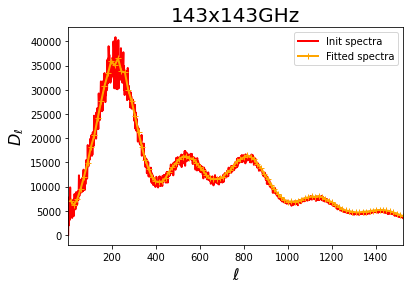

In [20]:
cmb_cls = mod.CMB(ell=np.linspace(0,lmax,lmax+1))
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)
cl_init = cmb.eval()
cl_plot = hp.anafast(hp.synfast(cl_init[fr,fr,:], nside = 512))

plt.figure()
ell_test = np.linspace(0,lmax,lmax+1)
# plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*cov_opti_deriv[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,ell_test**2*cl_plot,alpha =1,lw=2, c = 'red', label = 'Init spectra')
plt.plot(ell_mean,ell_mean**2*lst[0][fr,fr,:],alpha = 1.,lw=2, c = 'orange', label = 'Fitted spectra', marker = '+', 
         ls = None)

plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax-10)
# plt.ylim(1e-5,40000)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('{:d}x{:d}GHz'.format(int(freqs[fr]),int(freqs[fr])), fontsize = 20)
# plt.yscale('log')
plt.legend()
# plt.savefig('/Users/benjamin_brng/Desktop/cl_{:d}GHz_cmb.png'.format(int(freqs[fr])))
plt.show()

[0.00421788 0.00433423 0.00398517 0.00189077 0.00125082 0.00191986
 0.00581776]
[-4.26714508e-03 -4.43432622e-03 -3.92820792e-03  1.66371385e-03
 -1.24153517e-03  4.15840877e-05  1.04372604e-01]


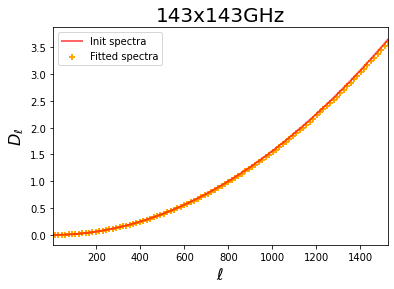

In [13]:
nwhite = np.array([145.,149.,137.,65.,43.,66.,200.])*np.pi/180./60./10.
noise = mod.WhiteNoise(ell=np.linspace(0,lmax,lmax+1), nu=freqs, nwhite=nwhite)
cl_init = noise.eval()

print(nwhite)
print(param_optimised_deriv['kwseq'][-1]['nwhite'])

plt.figure()
ell_test = np.linspace(0,lmax,lmax+1)
# plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*cov_opti_deriv[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,ell_test**2*cl_init[fr,fr,:],alpha = .6,lw=2, c = 'red', label = 'Init spectra')
plt.scatter(ell_mean,ell_mean**2*lst[2][fr,fr,:],alpha = 1.,lw=2, c = 'orange', label = 'Fitted spectra', marker='+')
plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax-10)
# plt.ylim(1e-5,40000)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('{:d}x{:d}GHz'.format(int(freqs[fr]),int(freqs[fr])), fontsize = 20)
# plt.yscale('log')
plt.legend()
# plt.savefig('/Users/benjamin_brng/Desktop/cl_{:d}GHz_noise.png'.format(int(freqs[fr])))
plt.show()